<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/VT_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras.models as models
# from keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D,MaxPooling2D,ZeroPadding2D
from keras.optimizers import adam

Using TensorFlow backend.


In [2]:

import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') 
dataDict = pickle.load(f,encoding='bytes')
print(type(dataDict))   # dict
print(len(dataDict))  #220=11（类别）×20（20个snr）

data = []
labels = []
for d in dataDict:
   signals=dataDict[d]
   for s in signals:
     data.append(np.array(s))
     labels.append(d)
data = np.array(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)
print(labels)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
<class 'dict'>
220
(162060, 2, 128)
(162060, 2)
[[b'QPSK' b'2']
 [b'QPSK' b'2']
 [b'QPSK' b'2']
 ...
 [b'WBFM' b'12']
 [b'WBFM' b'12']
 [b'WBFM' b'12']]


In [3]:
# 划分数据集 手动（固定的）和自动（可随机选）

# 使用函数分测试集和训练集
# from sklearn.model_selection import train_test_split
# xTrain, xTest, yTrain, yTest = train_test_split(data,labels, test_size=0.5, random_state=62)

indices = random.sample(range(0,162060),162060)
xTrain = []
yTrain = []
iTrain = []
for i in range(0,81030):
  xTrain.append(data[indices[i]])
  yTrain.append(labels[indices[i]])
  iTrain.append(indices[i])
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
iTrain = np.array(iTrain)

xTest = []
yTest = []
iTest = []
for i in range(81030, 162060):
  xTest.append(data[indices[i]])
  yTest.append(labels[indices[i]])
  iTest.append(indices[i])
xTest = np.array(xTrain)
yTest = np.array(yTrain)
iTest = np.array(iTest)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
print(iTrain.shape)
print(iTest.shape)

(81030, 2, 128)
(81030, 2)
(81030, 2, 128)
(81030, 2)
(81030,)
(81030,)


In [4]:

# one-hot enconding
#Sklearn’s one hot encoder doesn’t actually know how to convert categories to numbers,
#it only knows how to convert numbers to binary. We have to use the labelencoder first.
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()

yTrain_SNR = yTrain[:,1]
yTest_SNR = yTest[:,1]
print(yTrain_SNR.shape)
print(yTest_SNR.shape)
print(yTrain_SNR)
print(yTest_SNR)
print(yTest[81028])  #随便找一个例子看一下输出结果是否正确
print(yTest_SNR[81028])

yTrain_le = le.fit_transform(yTrain[:, 0])
yTest_le = le.fit_transform(yTest[:, 0])
print(yTrain_le.shape)
print(yTest_le.shape)
print(yTrain_le[81028])
print(yTest_le[81028])   #label编码后

yTrain_le = yTrain_le.reshape(len(yTrain_le), 1)
yTest_le = yTest_le.reshape(len(yTest_le), 1)

enc = OneHotEncoder(categories = 'auto',sparse = False )  #将分类特征的每个元素转化为一个可以用来计算的值
yTrain_ohe = enc.fit_transform(yTrain_le)  # 如果不加 toarray() 的话，输出的是稀疏的存储格式，即索引加值的形式，也可以通过参数指定 sparse = False 来达到同样的效果
yTest_ohe = enc.fit_transform(yTest_le)
print(yTrain_ohe[81028])  #onehot编码后
print(yTest_ohe[81028])  #onehot编码后


(81030,)
(81030,)
[b'-14' b'-14' b'-18' ... b'2' b'6' b'4']
[b'-14' b'-14' b'-18' ... b'2' b'6' b'4']
[b'GFSK' b'6']
b'6'
(81030,)
(81030,)
5
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [38]:
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns


dr = 0.5 # dropout rate (%)
model = models.Sequential()
in_shp = [2, 128]
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))  #(80,2,3)改成了（80，1，3）
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense(11, init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Dense(11,activation='softmax'))
# model.add(Reshape(11)) 
# 加上metrics=['acc']这一句
# model.compile(loss='categorical_crossentropy', optimizer='adam') 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 4, 256)         98560     
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 4, 256)         0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 1, 8, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 6, 80)          61520     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 6, 80)        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (1, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, name="dense2", kernel_initializer="he_normal")`


In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs=50
batch_size=1000
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint('best.hdf5weights.best2.hdf5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
model.fit(xTrain, yTrain_ohe, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[es, mc])  #不加 metrics=['accuracy']这一句时，结果显示是loss和val_loss，不显示准去率

Train on 64824 samples, validate on 16206 samples
Epoch 1/50
64824/64824 [==============================] - 9s 136us/step - loss: 1.9827 - accuracy: 0.2829 - val_loss: 1.9583 - val_accuracy: 0.2963
Epoch 2/50
 1000/64824 [..............................] - ETA: 8s - loss: 1.9401 - accuracy: 0.2940

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


64824/64824 [==============================] - 9s 137us/step - loss: 1.9719 - accuracy: 0.2849 - val_loss: 1.9504 - val_accuracy: 0.3001
Epoch 3/50
64824/64824 [==============================] - 9s 136us/step - loss: 1.9688 - accuracy: 0.2831 - val_loss: 1.9459 - val_accuracy: 0.2975
Epoch 4/50
64824/64824 [==============================] - 9s 137us/step - loss: 1.9579 - accuracy: 0.2875 - val_loss: 1.9329 - val_accuracy: 0.3004
Epoch 5/50
64824/64824 [==============================] - 9s 136us/step - loss: 1.9460 - accuracy: 0.2885 - val_loss: 1.9243 - val_accuracy: 0.3002
Epoch 6/50
64824/64824 [==============================] - 9s 137us/step - loss: 1.9378 - accuracy: 0.2907 - val_loss: 1.9241 - val_accuracy: 0.3025
Epoch 7/50
64824/64824 [==============================] - 9s 137us/step - loss: 1.9335 - accuracy: 0.2917 - val_loss: 1.9063 - val_accuracy: 0.3054
Epoch 8/50
64824/64824 [==============================] - 9s 137us/step - loss: 1.9175 - accuracy: 0.2958 - val_loss: 1.892

In [47]:
batch_size=1000
score = model.evaluate(xTest, yTest_ohe, verbose=0, batch_size=batch_size)
print (score)   #结果是 1.9665707177208425，不是100%下的结果，这个结果应该是默认的loss
print (score[1])  #报错 'float' object is not subscriptable
print ('loss： %.4lf' % score[0])
print('accuracy: ', score[1])

[1.7418596819125913, 0.30427002906799316]
0.30427002906799316
loss： 1.7419
accuracy:  0.30427002906799316


Accuracy for SNR =  -20  is  14.65517282485962
Accuracy for SNR =  -18  is  15.956120193004608
Accuracy for SNR =  -16  is  14.997495710849762
Accuracy for SNR =  -14  is  14.909268915653229
Accuracy for SNR =  -12  is  15.499146282672882
Accuracy for SNR =  -10  is  15.814536809921265
Accuracy for SNR =  -8  is  18.428781628608704
Accuracy for SNR =  -6  is  24.40711408853531
Accuracy for SNR =  -4  is  38.03513944149017
Accuracy for SNR =  -2  is  40.476781129837036
Accuracy for SNR =  0  is  40.31296670436859
Accuracy for SNR =  2  is  38.766297698020935
Accuracy for SNR =  4  is  39.26380276679993
Accuracy for SNR =  6  is  38.943490386009216
Accuracy for SNR =  8  is  39.15175199508667
Accuracy for SNR =  10  is  39.57915902137756
Accuracy for SNR =  12  is  39.21375870704651
Accuracy for SNR =  14  is  39.945852756500244
Accuracy for SNR =  16  is  40.004804730415344
Accuracy for SNR =  18  is  39.8723304271698


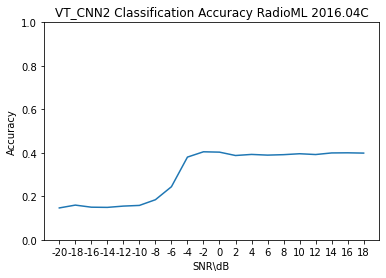

In [48]:

"""###Evaluate Test set"""


filepath = "VT_CNN2.hdf5"
model.save(filepath)

SNR = np.unique(labels[:,1])
SNR = list(map(int, SNR))
SNR.sort()
SNR = list(map(str, SNR))

from keras.models import load_model
saved_model = load_model('VT_CNN2.hdf5')

yTest_SNR_str = []
for i in yTest_SNR:
  yTest_SNR_str.append(str(i).split('\'')[1])

accuracy = []

for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest[index])

    y = np.array(SNR_Y)
    # print(y)
    x = np.array(SNR_X)
    result = model.evaluate(x, y, verbose=2)
    print('Accuracy for SNR = ', s, ' is ', result[1] * 100)
    accuracy.append(result[1])

import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(SNR, accuracy)
plt.title('VT_CNN2 Classification Accuracy RadioML 2016.04C')
plt.xlabel('SNR\dB')
plt.ylabel('Accuracy')
plt.show()


# 曲线不合理：先降后升现象
# 解决方法：多画几次


In [0]:
os.environ["KERAS_BACKEND"] = "theano"
import theano as th
import theano.tensor as T

import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam

dr = 0.5 # dropout rate (%)
model = models.Sequential()
# # model.add(Reshape([1]+in_shp, input_shape=in_shp))
# model.add(Reshape((1,2,128), input_shape=(2,128)))
# model.add(ZeroPadding2D((0, 2)))
# # model.add(Conv2D(filters=256, kernel_size=(1,3), data_format='channels_first', activation='relu', padding='valid'))  #module 'tensorflow._api.v2.config' has no attribute 'experimental_list_devices'
# model.add(Conv2D(filters=256, kernel_size=(1,3), data_format='channels_first', activation='relu', padding='valid'))
# model.add(Dropout(dr))
# model.add(ZeroPadding2D((0, 2)))
# model.add(Conv2D(filters=80, kernel_size=(2,3), data_format='channels_first', activation='relu', padding='valid'))
# model.add(Dropout(dr))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(dr))
# model.add(Dense( 11, activation='softmax' ))
# model.add(Reshape(11))
# model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.summary()
# in_shp=[2,128]
# model.add(Reshape([1]+in_shp, input_shape=in_shp))

model.add(Reshape((1,2,128), input_shape=(2,128)))
model.add(Conv2D(256,(1,3),activation='relu',padding='valid'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80,(2,3),activation='relu',padding='valid'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(11,activation='relu'))
model.add(Dense(11,activation='softmax'))
model.add(Reshape(11))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()



model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.summary()  This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 
model.bulit(input_shape)
model.summary()

In [0]:
"""##Neural Networks
###CNN:VT_CNN2
"""
# from keras.models import Sequential
# from keras.layers import Conv1D, Conv2D, Flatten, Dense, Reshape
# from keras import optimizers
# import keras.models as models

from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D,MaxPooling2D,ZeroPadding2D
from keras.optimizers import adam

dr = 0.5
model = models.Sequential()
# model.add(Reshape(1,2,128),input_shape=(2,128))
model.add(Reshape((1,2,128), input_shape=(2,128)))
model.add(ZeroPadding2D((0,2))) # 为什么加两个括号就不报错了
# model.add(Convolution2D(256,1,3),border_mode='valid',activation='relu',name='conv1',init='glorot_uniform') # 后面这些项都算是con里面的吗
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
model.add(Dropout(dr))
# model.add(ZeroPadding2D(0,2))
model.add(Convolution2D(80,2,3,border_mode='valid',activation='relu',name='conv2',init='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256,activation='relu',init='he_normal',name='dense1'))
model.add(Dropout(dr))
# model.add(Dense(len(classes),init='he_normal',name=dense2''))
model.add(Dense( 11, init='he_normal', name="dense2" ))
model.add(activation='softmax')
# model.add(Reshape([len(classes)]))
model.add(Reshape(11))
model.compile(loss='categorial_crossentropy',optimize='adam')
model.summary()

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint('best.hdf5weights.best2.hdf5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)
model.fit(xTrain, yTrain_ohe, validation_split=0.05, shuffle=True, batch_size=1000, epochs=10, verbose=1, callbacks=[es, mc])
